In [40]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

In [100]:
plate_cascade = cv2.CascadeClassifier('C:\\Users\\soham\\OneDrive\\Documents\\IoT_DA2\\Dataset\\haarcascader_russian_plate_number.xml')

In [101]:
def detect_plate(img, text=''): # the function detects and perfors blurring on the number plate.
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.2, minNeighbors = 7) # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
    for (x,y,w,h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :] # extracting the Region of Interest of license plate for blurring.
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x+2,y), (x+w-3, y+h-5), (51,181,155), 3) # finally representing the detected contours by drawing rectangles around the edges.
    if text!='':
        plate_img = cv2.putText(plate_img, text, (x-w//2,y-h//2), 
                                cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.5, (51,181,155), 1, cv2.LINE_AA)
        
    return plate_img, plate # returning the processed image.

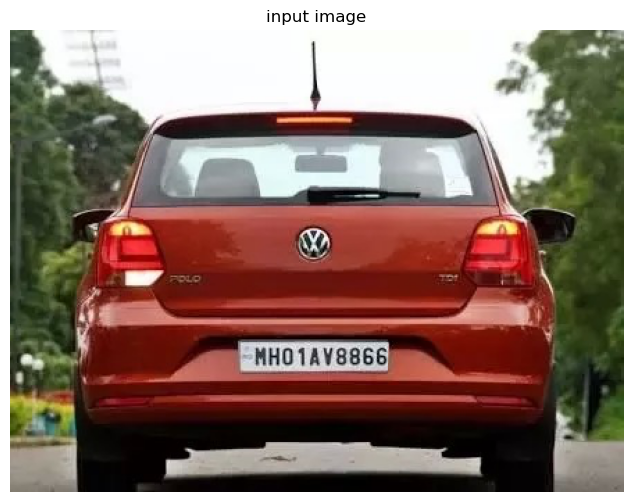

In [102]:
# Testing the above function
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

img = cv2.imread('C:\\Users\\soham\\OneDrive\\Documents\\Dataset\\Car License Plate Detection\images\\Cars108.png')
display(img, 'input image')

In [104]:
# Getting plate from the processed image
output_img, plate = detect_plate(img)

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\objdetect\src\cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'cv::CascadeClassifier::detectMultiScale'


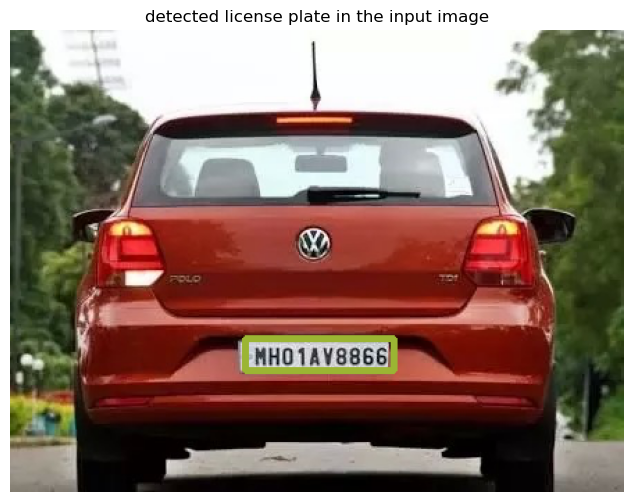

In [91]:
display(output_img, 'detected license plate in the input image')

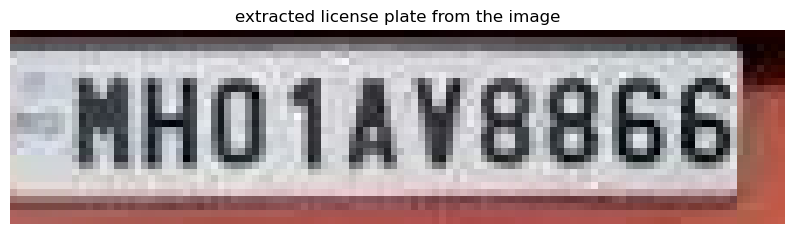

In [92]:
display(plate, 'extracted license plate from the image')

In [93]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res


In [94]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

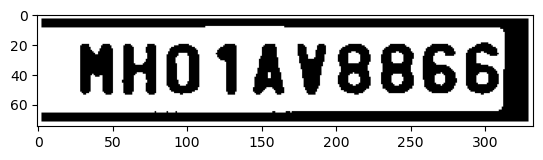

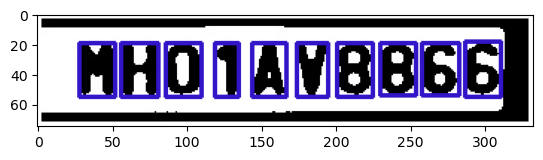

In [95]:
# Let's see the segmented characters
char = segment_characters(plate)

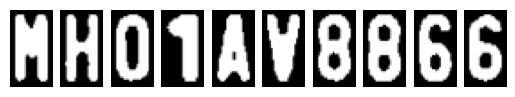

In [96]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

In [51]:
import tensorflow.keras.backend as K
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = 'C:/Users/soham/OneDrive/Documents/IoT_DA2/Dataset/data/data'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [52]:
# Metrics for checking the model performance while training
def f1score(y, y_pred):
  return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
  return tf.py_function(f1score, (y, y_pred), tf.double)

In [53]:
import tensorflow as tf

# Check for available GPUs (optional)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available:", len(physical_devices))

# Define your model
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=[custom_f1score])

Num GPUs Available: 1


In [54]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 16)        23248     
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 32)        131104    
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 64)        131136    
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 64)        65600     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 64)          0         
                                                      

In [55]:
class stop_training_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_custom_f1score') > 0.99):
      self.model.stop_training = True

In [57]:
batch_size = 5
callbacks = [stop_training_callback()]
model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size, 
      validation_data = validation_generator, 
      epochs = 50, verbose=1, callbacks=callbacks)

Epoch 1/50
172/172 [==============================] - 1s 7ms/step - loss: 0.2291 - custom_f1score: 0.9012 - val_loss: 0.1574 - val_custom_f1score: 0.9554
Epoch 2/50
172/172 [==============================] - 1s 6ms/step - loss: 0.0940 - custom_f1score: 0.9651 - val_loss: 0.1354 - val_custom_f1score: 0.9435
Epoch 3/50
172/172 [==============================] - 1s 6ms/step - loss: 0.1455 - custom_f1score: 0.9593 - val_loss: 0.1741 - val_custom_f1score: 0.9226
Epoch 4/50
172/172 [==============================] - 1s 6ms/step - loss: 0.1948 - custom_f1score: 0.9244 - val_loss: 0.3951 - val_custom_f1score: 0.8958
Epoch 5/50
172/172 [==============================] - 1s 6ms/step - loss: 0.2846 - custom_f1score: 0.9128 - val_loss: 0.1134 - val_custom_f1score: 0.9628
Epoch 6/50
172/172 [==============================] - 1s 6ms/step - loss: 0.1586 - custom_f1score: 0.9535 - val_loss: 0.1099 - val_custom_f1score: 0.9494
Epoch 7/50
172/172 [==============================] - 1s 6ms/step - loss: 0.

In [97]:
def fix_dimension(img):
  new_img = np.zeros((28, 28, 3))
  for i in range(3):
    new_img[:, :, i] = img
  return new_img

def show_results():
  dic = {}
  characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
  for i, c in enumerate(characters):
    dic[i] = c

  output = []
  for i, ch in enumerate(char):
    img_ = cv2.resize(ch, (28, 28), interpolation=cv2.INTER_AREA)
    img = fix_dimension(img_)
    img = img.reshape(1, 28, 28, 3)  # Ensure shape matches model input

    # Updated prediction using np.argmax
    y_ = np.argmax(model.predict(img), axis=-1)[0]
    character = dic[y_]
    output.append(character)

  plate_number = ''.join(output)
  return plate_number

print(show_results())


1/1 [==============================] - 0s 38ms/step
MH01AV8866


1/1 [==============================] - 0s 43ms/step


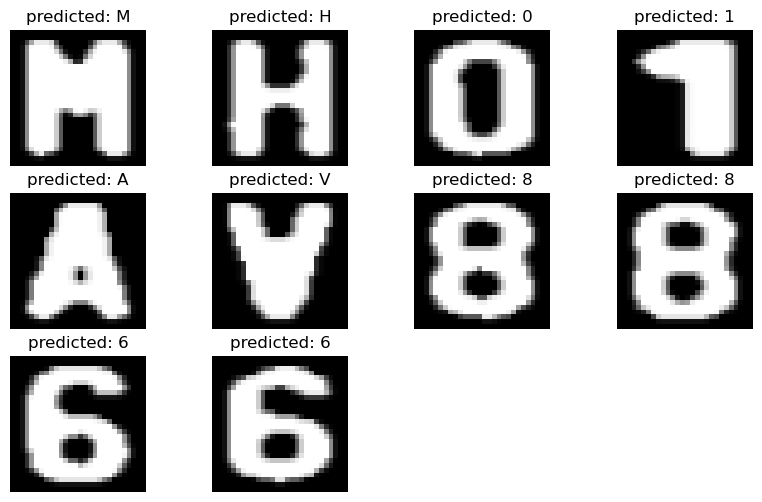

In [98]:
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

In [36]:
model.save("pred_plate.h5")

In [37]:
import tensorflow as tf

def custom_f1score(y_true, y_pred):
  # Define your custom F1 score logic here
  ...

# Load model with custom object
model = tf.keras.models.load_model("pred_plate.h5", custom_objects={"custom_f1score": custom_f1score})

# Proceed with conversion
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


INFO:tensorflow:Assets written to: C:\Users\soham\AppData\Local\Temp\tmpwgwlde9o\assets


INFO:tensorflow:Assets written to: C:\Users\soham\AppData\Local\Temp\tmpwgwlde9o\assets


In [99]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="C:\\Users\\soham\\OneDrive\\Documents\\IoT_DA2\\pred_plate.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load the cascade for detecting plates
plate_cascade = cv2.CascadeClassifier('C:\\Users\\soham\\OneDrive\\Documents\\IoT_DA2\\Dataset\\indian_license_plate.xml')

# Function for detecting plate from image
def detect_plate(img, text=''): 
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor=1.2, minNeighbors=7)
    for (x,y,w,h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :]
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x+2,y), (x+w-3, y+h-5), (51,181,155), 3)
    if text!='':
        plate_img = cv2.putText(plate_img, text, (x-w//2,y-h//2), 
                                cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.5, (51,181,155), 1, cv2.LINE_AA)
        
    return plate_img, plate

# Function to segment each character from the license plate
def segment_characters(image):
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    dimensions = [LP_WIDTH/6, LP_WIDTH/2, LP_HEIGHT/10, 2*LP_HEIGHT/3]

    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

# Function to find contours
def find_contours(dimensions, img) :
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX)

            char_copy = np.zeros((44,24))
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            char = cv2.subtract(255, char)

            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy)
            
    plt.show()
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])
    img_res = np.array(img_res_copy)

    return img_res

# Function to fix dimension of image
def fix_dimension(img):
    new_img = np.zeros((28, 28, 3))
    for i in range(3):
        new_img[:, :, i] = img
    return new_img

# Function to show results after prediction
def show_results(char, image):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for i, ch in enumerate(char):
        img_ = cv2.resize(ch, (28, 28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1, 28, 28, 3)  # Ensure shape matches model input

        y_ = np.argmax(interpreter.predict(img), axis=-1)[0]
        character = dic[y_]
        output.append(character)

    plate_number = ''.join(output)
    return plate_number

# Load the image
image_path = "C:\\Users\\soham\\OneDrive\\Documents\\Dataset\\Car License Plate Detection\\images\\Cars108.jpg"
image = cv2.imread(image_path)

# Detect plate from the image
output_img, plate = detect_plate(image)

# Display the detected plate
plt.imshow(output_img)
plt.title('Detected License Plate')
plt.axis('off')
plt.show()

# Extract license plate and display it
if plate is not None:
    display(plate, 'Extracted License Plate')

# Segment characters from the license plate
char = segment_characters(plate)

# Display the segmented characters
if char:
    for i in range(min(10, len(char))):
        plt.subplot(1, 10, i+1)
        plt.imshow(char[i], cmap='gray')
        plt.axis('off')
    plt.show()
    print("Predicted Plate Number:", show_results(char, image))
else:
    print("No characters were segmented.")


AttributeError: 'NoneType' object has no attribute 'copy'